# HoG classifier

**Overview**
This exercise builds on the previous HoG exercise
, but can be completed independently.


<article class="message">
    <div class="message-body">
        <strong>List of individual tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#sklearn">Task 1: Implement a classifier</a>
            </li>
            <li>
            <a href="#sklearn1">Task 2: Evaluate the classifier</a>
            </li>
            <li>
            <a href="#sliding">Task 3: Sliding window</a>
            </li>
            <li>
            <a href="#calc_HoG">Task 4: Classifying the test image</a>
            </li>
            <li>
            <a href="#reflect">Task 5: Reflections</a>
            </li>
        </ul>
    </div>
</article>

The cell below imports the necessary libraries, loads an example image and extracts and plots the HoG features along the original image. 


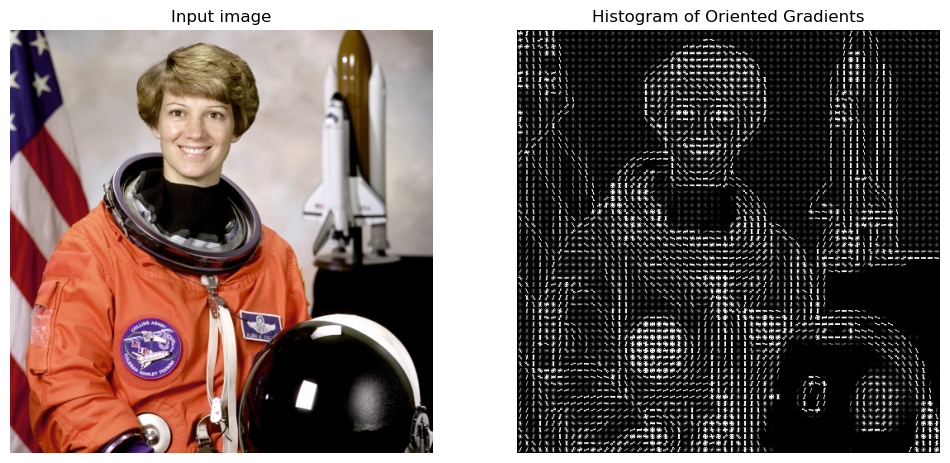

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import chain

from skimage import data, transform, feature, exposure
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from skimage.color import rgb2gray
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.svm import LinearSVC
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

image = data.astronaut()

fd, HoG_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
HoG_image_rescaled = exposure.rescale_intensity(HoG_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(HoG_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Creating the training data
The following steps constructs the training data, which comprises of HoG features extracted from images containing faces and non-faces. The constructed set is used for training a binary classification model.
**Face Images (Positive class)**
Use the "Labeled Faces in the Wild" dataset ("LFW") for the images containing faces as provided by scikit-learn. The cell below loads the dataset, extracts the facial images, and displays a selection of these images for visualization. 

**Info**
When first loading the dataset, please be aware that the code may require a few minutes to finish execution.



(13233, 62, 47)


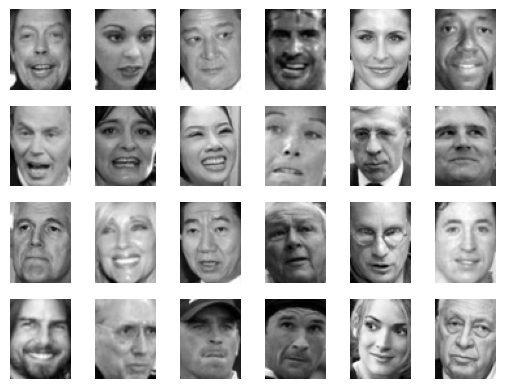

In [2]:
faces = fetch_lfw_people()

face_images = faces.images
print(face_images.shape) # 13233 face images to use for training

# Visualize Positive Set (face images)

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_images[500 * i], cmap='gray')
    axi.axis('off')

**Non-face Images (Negative class)**
For non-face images other images from the Scikit-Image library are used. The cell below loads these images. The `PatchExtractor`
 method is used for data augmentation.


In [3]:
# negative data samples
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
# images = []

images = [data.camera(), data.coins(),data.text(),data.moon(),data.page(),data.clock(),data.coffee(),data.hubble_deep_field()]
img = []
for im in images:
    if len(im.shape)==3:
        img.append(rgb2gray(im))
    else:
        img.append(im)

### Make patches of the different negative samples to generate a larger dataset

def extract_patches(img, N, scale=1.0, patch_size=face_images[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

non_face_images = np.vstack([extract_patches(im, 1000, scale)
                              for im in img for scale in [0.5,1.0,2.0]]) # [0.5, 1.0, 2.0]
print(non_face_images.shape)

(24000, 62, 47)


The cell below visualizes the newly created non-face image patches:


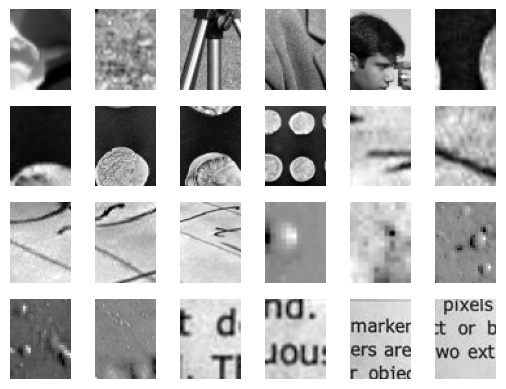

In [4]:
# Visualize Negative Set

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(non_face_images[600 * i], cmap='gray')
    axi.axis('off')

The cell below combines the face and the non face images, then extracts the HoG features from the combined set. It also creates the target labels for the newly assembled training dataset. 


In [5]:
X_train = np.array([hog(im, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                    for im in chain(face_images, non_face_images)])


Y_train = np.zeros(X_train.shape[0])
Y_train[:face_images.shape[0]] = 1

## Training a classifier
Train a linear classifier using HoG features.

---
**Task 1 (easy): Implement a classifier👩‍💻**
The cell below contains a classification model (SVM). Complete the following steps in the cell below:
1. Fit the model to the training data.

2. Calculate and print the accuracy of the classifier on the training data.

3. Construct and plot a confusion matrix of the model predictions on the training set.



---

[[23970    30]
 [  113 13120]]
Accuracy: 0.9961593210324174
Precision: 0.9953078935348586
Recall: 0.99875
f1: 0.9970259759166441
Specificity: 0.9914607420841834
MCC: 0.9916176339425887


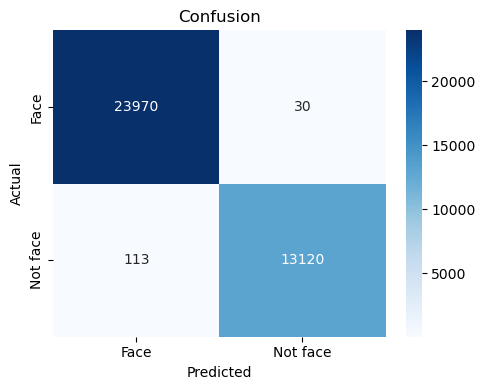

In [16]:
from confusion_util import plot_confusion_matrix_sns

model = LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0)

# implement model from scikit-learn
trained_model = model.fit(X_train, Y_train)
pred = trained_model.predict(X_train)
correct = 0
for i in range(len(pred)):
    if pred[i] == Y_train[i]:
        correct += 1

cm = confusion_matrix(Y_train, pred)
print(cm)
print("Accuracy:", correct/len(pred))
precision = cm[0][0] / (cm[0][0] + cm[1][0])
print("Precision:", precision)
recall = cm[0][0] / (cm[0][0] + cm[0][1])
print("Recall:", recall)
print("f1:", 2*((precision*recall) / (precision+recall)))
print("Specificity:", cm[1][1] / (cm[1][1]+cm[1][0]))
print("MCC:", (cm[0][0]*cm[1][1]-cm[1][0]*cm[0][1]) / (np.sqrt((cm[0][0] + cm[1][0]) * (cm[0][0] + cm[0][1]) * (cm[1][1] + cm[1][0]) * (cm[1][1] + cm[0][1]))))

plot_confusion_matrix_sns(cm, "Confusion", "Face", "Not face")




---
**Task 2 (easy): Evaluate the classifier💡📽️**
1. Reflect on the model performance based on the confusion matrix (accuracy, precision, recall, f1, specificity, MCC). 


---

In [0]:
#Write your reflections here...

"""
Looking at the accuracy and the confusion matrix, it looks like the model is doing very well.
Looking at all our metrics we can see that we are scoring well in all of them. This looks like a pretty good model
"""

## Testing on new images
The following tasks ([Task 3](#sliding)-[Task 5](#reflect) ) are about implementing a sliding-window function that breaks an image into patches, extracts HoG features from each patch, and classifies them as face (1) or non-face (0) using the trained model.


In [0]:
# Load a test image
test_img = data.astronaut()
test_img = rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off')
print(test_img.shape)


---
**Task 3 (hard): Sliding window👩‍💻**
1. Implement the method `sliding_windows`
 that takes the test image and extracts image patches from it. The function should:
    - Iteratively slide over the entire image and extract image patches of the same size as the inputs the classifier was trained on.
    - Return a tuple of the coordinates of the upper left corner of each subimage patch, and the patch itself.




---

In [0]:
# Sliding Window function - Goes Over the image patch by patch
# and computes the HoG features for each patch.

def sliding_window(img, patch_size=face_images[0].shape, istep=, jstep=):
    indicies = []
    patches = []
    ...
    return indicies, patches

# Write you code iterating over the test image here.
# EASIEST approach is to use a foor loop for each image dimension


---
**Task 4 (medium): Classifying the test image👩‍💻**
In the following task you have to:
1. Extract the HoG features for all patches from the test image (`test_img`
) by making use of the `sliding_window`
 and `HoG`
 functions. Store the features in an array called `HoG_patches`
 and the corresponding indices in an array called `indices`
.

2. Use the model to classify the extracted HoG patches and store the results in an array called `labels`
.

3. Use the existing code to visualize the detections. 



---

In [0]:
# Apply sliding window function to test_img

# Write your code here


# Visualize the detections
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = face_images[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

## Reflections

---
**Task 5 (easy): Reflections💡**
- Summarize the overall process of face detection implemented in this exercise. 
- There are multiple overlapping boxes of the same detected face in the test image. How could you ensure that a face is only detected once? 
- Consider the following steps: training data construction, model fitting, test images. How could the face detection pipeline be improved?


---

In [0]:
#Write your reflections here...